In [105]:
import os
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import datetime as dt

In [70]:
df = pd.read_csv('./data/indexProcessed.csv', parse_dates=['Date'])
df.head(5)

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


In [71]:
# prepare dataset
df.dtypes

Index                object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
CloseUSD            float64
dtype: object

In [72]:
def specific_date(stock, start, end):
    company_data = df[df['Index'] == stock]
    return company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]

In [73]:
companies = df['Index'].unique().tolist()

stock = random.choice(companies)
start_date = dt.datetime(2000,1,1)
end_date = dt.datetime(2020,1,1)

df_spec = specific_date(stock, start_date, end_date)
df_spec['Date'] = pd.to_datetime(df_spec['Date'])

In [74]:
df_spec.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
35740,000001.SS,2000-01-04,1368.692993,1407.517944,1361.213989,1406.370972,1406.370972,0.0,225.019356
35741,000001.SS,2000-01-05,1407.828979,1433.780029,1398.322998,1409.682007,1409.682007,0.0,225.549121
35742,000001.SS,2000-01-06,1406.036011,1463.954956,1400.253052,1463.942017,1463.942017,0.0,234.230723
35743,000001.SS,2000-01-07,1477.154053,1522.824951,1477.154053,1516.604004,1516.604004,0.0,242.656641
35744,000001.SS,2000-01-10,1531.712036,1546.723022,1506.404053,1545.112061,1545.112061,0.0,247.217930


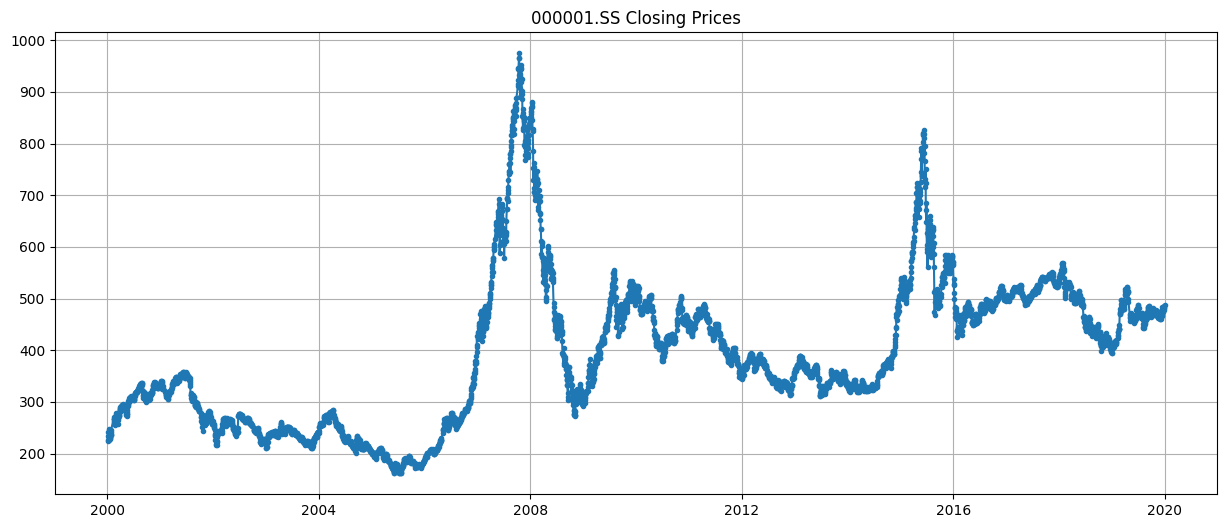

In [75]:
# plotting chart
plt.figure(figsize=(15,6))
plt.plot(df_spec['Date'], df_spec['CloseUSD'], marker='.')
plt.title(f'{stock.upper()} Closing Prices')
plt.grid(True)

In [76]:
# scaling dataset
df_spec_cl = df_spec.reset_index()['CloseUSD']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(df_spec_cl).reshape(-1, 1))

In [79]:
# splitting dataset
train_size = 0.8
train_data, test_data = scaled_data[:(int(len(scaled_data) * train_size))], scaled_data[(int(len(scaled_data) * train_size)):]

In [92]:
# sequence length
n_past = 60

# prepare sequences
X_tr, Y_tr = [], []
for n in range(n_past, len(train_data)):
    X_tr.append(train_data[n - n_past:n, 0])
    Y_tr.append(train_data[n, 0])
X_tr, Y_tr = np.array(X_tr), np.array(Y_tr)

X_te, Y_te = [], []
for n in range(n_past, len(test_data)):
    X_te.append(test_data[n - n_past:n, 0])
    Y_te.append(test_data[n, 0])
X_te, Y_te = np.array(X_te), np.array(Y_te)

print(f'Training set size: {X_tr.shape}, {Y_tr.shape} \nTesting set size: {X_te.shape}, {Y_te.shape}')

Training set size: (3812, 60), (3812,) 
Testing set size: (908, 60), (908,)


In [93]:
# reshape data for lstm
# currently: (samples,timesteps) -> (samples,timesteps,feautures)
X_tr = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
X_te = X_te.reshape(X_te.shape[0], X_te.shape[1], 1)

In [97]:
model = Sequential([
    LSTM(units=60, return_sequences=True, input_shape=(X_tr.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=60, return_sequences=True),
    Dropout(0.2),
    LSTM(units=60),
    Dropout(0.2),
    Dense(units=1),
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

I0000 00:00:1723928689.381769    7886 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-17 23:04:49.738796: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/bence/code/neural/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 60)         │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,021 (285.24 KB)

 Trainable params: 73,021 (285.24 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
checkpoints = ModelCheckpoint(filepath = f'model_{stock}.keras', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_tr, Y_tr, validation_data=(X_te, Y_te), epochs=25, batch_size=32, verbose=1, callbacks=[checkpoints, early_stop])

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - loss: 0.0151 - val_loss: 6.4157e-04
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.0019 - val_loss: 7.8752e-04
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0016 - val_loss: 4.6864e-04
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0014 - val_loss: 1.9240e-04
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0013 - val_loss: 1.7302e-04
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0011 - val_loss: 1.7842e-04
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.0011 - val_loss: 3.2773e-04
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 9.7433e-04 - val_loss: 2.0982e-04
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 7.3440e-04 - val_loss: 7.9746e-04
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/ste

In [102]:
# predictions
train_predict = model.predict(X_tr)
test_predict = model.predict(X_te)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [110]:
# rmse calculations
print(f'Train RMSE: {math.sqrt(mean_squared_error(Y_tr, train_predict)):.2f}')
print(f'Test RMSE: {math.sqrt(mean_squared_error(Y_te, test_predict)):.2f}')

Train RMSE: 402.25
Test RMSE: 486.91


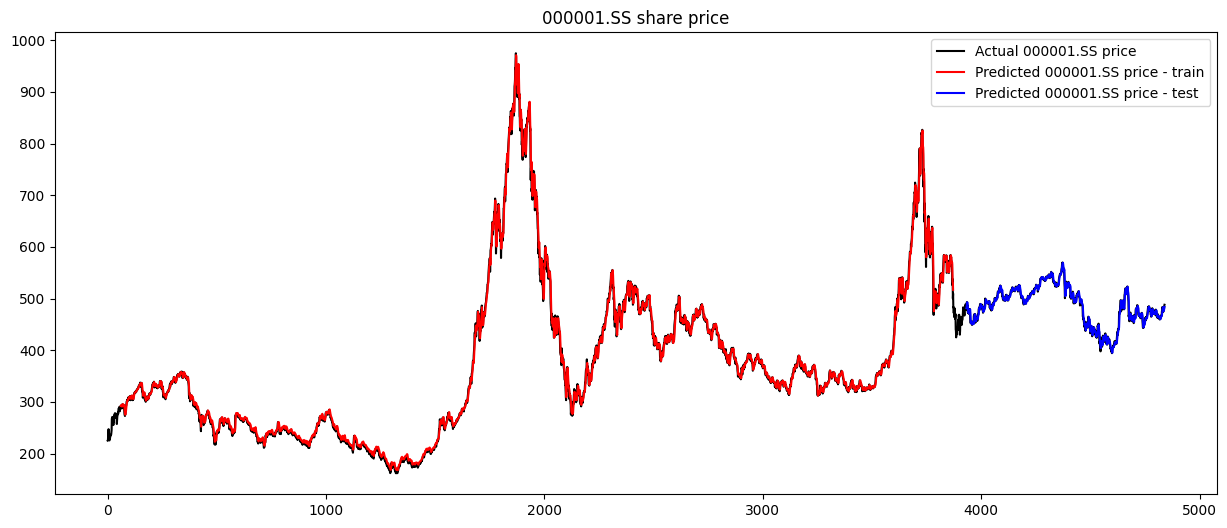

In [111]:
# plotting prediction on history data
look_back = 60 # days to look back

trainPreidctPlot = np.empty_like(df_spec_cl)
trainPreidctPlot[:] = np.nan
trainPreidctPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

testPredictPlot = np.empty_like(df_spec_cl)
testPredictPlot[:] = np.nan
test_start = len(df_spec_cl) - len(test_predict)
testPredictPlot[test_start:] = test_predict.flatten()

original_sd = scaler.inverse_transform(scaled_data)

plt.figure(figsize=(15,6))
plt.plot(original_sd, color='black', label=f"Actual {stock.upper()} price")
plt.plot(trainPreidctPlot, color='red', label=f"Predicted {stock.upper()} price - train")
plt.plot(testPredictPlot, color='blue', label=f"Predicted {stock.upper()} price - test")

plt.title(f"{stock.upper()} share price")
plt.legend()

In [112]:
# predicting & plotting next x days
PREDICT = 10

last_sequence = X_te[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

predictions = []
for _ in range(PREDICT):
    next_day_predict = model.predict(last_sequence)
    predictions.append(next_day_predict[0,0])
    last_sequence = np.roll(last_sequence, -1, axis=1) # shifting sequence by one day
    last_sequence[0, -1, 0] = next_day_predict # update last element

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/tmp/ipykernel_7886/50325905.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_sequence[0, -1, 0] = next_day_predict # update last element


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


([<matplotlib.axis.XTick at 0x7f87b065c2e0>,
 [Text(0, 0, 'Day1'),
  Text(1, 0, 'Day2'),
  Text(2, 0, 'Day3'),
  Text(3, 0, 'Day4'),
  Text(4, 0, 'Day5'),
  Text(5, 0, 'Day6'),
  Text(6, 0, 'Day7'),
  Text(7, 0, 'Day8'),
  Text(8, 0, 'Day9'),
  Text(9, 0, 'Day10')])

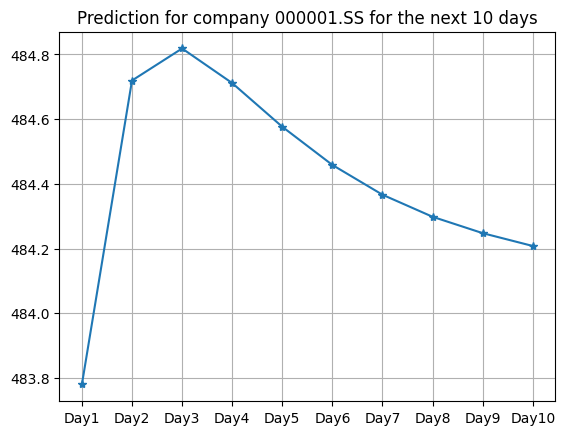

In [116]:
plt.plot(predictions, marker='*')
plt.title(f'Prediction for company {stock.upper()} for the next {PREDICT} days')
plt.grid(True)
plt.xticks(range(0, PREDICT), [f'Day{i+1}' for i in range(PREDICT)])

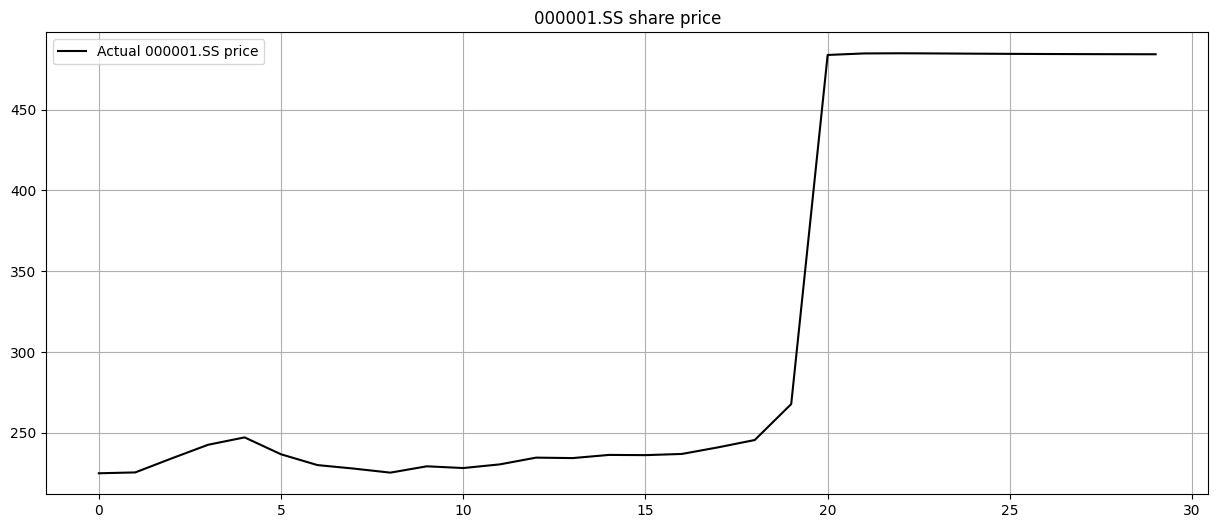

In [131]:
plt.figure(figsize=(15,6))
plt.plot(np.concatenate((original_sd[:PREDICT+10], predictions)), color='black', label=f"Actual {stock.upper()} price")

plt.grid(True)
plt.title(f"{stock.upper()} share price")
plt.legend()